In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

# LangGraph Retrieval Agent

[Retrieval Agents](https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents) are useful when we want to make decisions about whether to retrieve from an index.

To implement a retrieval agent, we simple need to give an LLM access to a retriever tool.

We can incorperate this into [LangGraph](https://python.langchain.com/docs/langgraph).

## Retriever

First, we index 3 blog posts.

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

Then we create a retriever tool.

In [4]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [tool]

from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Agent state
 
We will defined a graph.

A `state` object that it passes around to each node.

Our state will be a list of `messages`.

Each node in our graph will append to it.

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Nodes and Edges

We can lay out an agentic RAG graph like this:

* The state is a set of messages
* Each node will update (append to) state
* Conditional edges decide which node to visit next

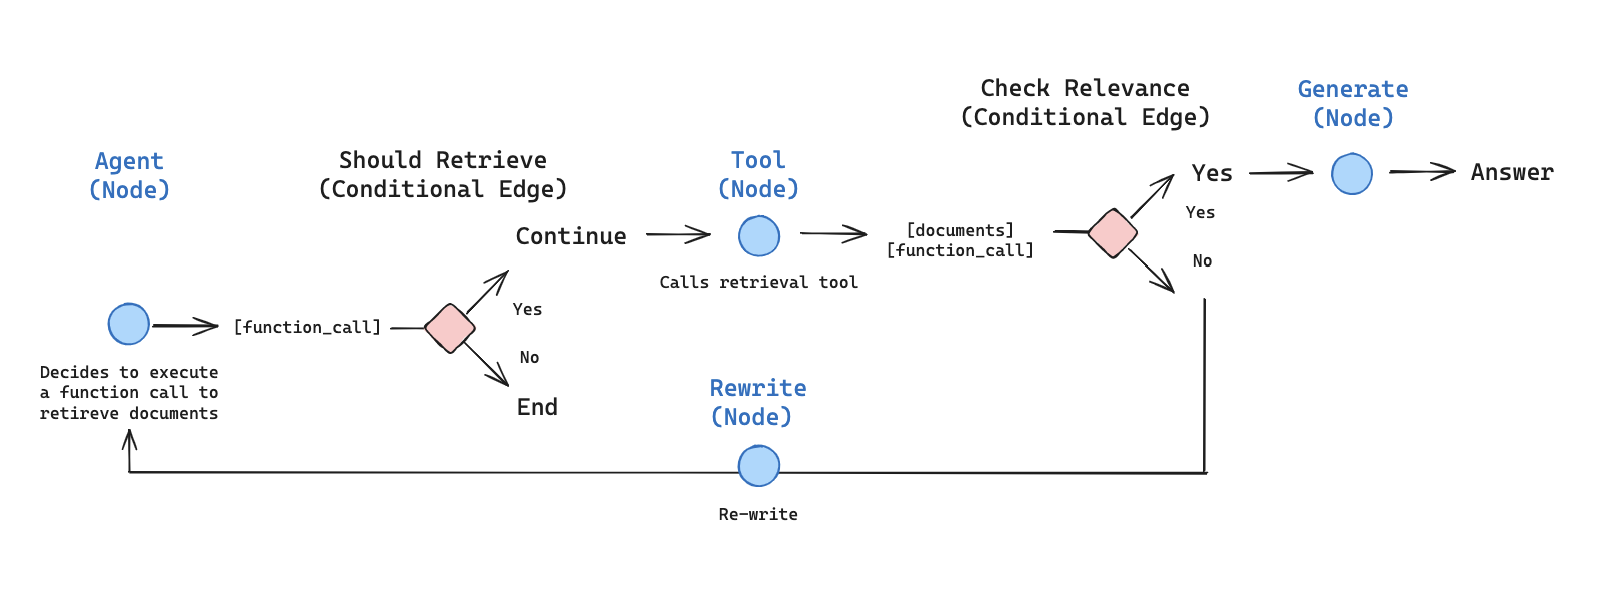

In [38]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser

### Edges


def should_retrieve(state):
    """
    Decides whether the agent should retrieve more information or end the process.

    This function checks the last message in the state for a function call. If a function call is
    present, the process continues to retrieve information. Otherwise, it ends the process.

    Args:
        state (messages): The current state

    Returns:
        str: A decision to either "continue" the retrieval process or "end" it
    """
    
    print("---DECIDE TO RETRIEVE---")
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        print("---DECISION: DO NOT RETRIEVE / DONE---")
        return "end"
    # Otherwise there is a function call, so we continue
    else:
        print("---DECISION: RETRIEVE---")
        return "continue"


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool | parser_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content
    
    score = chain.invoke(
        {"question": question, 
         "context": docs}
    )
    
    grade = score[0].binary_score

    if grade == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "yes"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score.binary_score)
        return "no"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response apended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-0125-preview")
    functions = [format_tool_to_openai_function(t) for t in tools]
    model = model.bind_functions(functions)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

def retrieve(state):
    """
    Uses tool to execute retrieval.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with retrieved docs
    """
    print("---EXECUTE RETRIEVAL---")
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    function_message = FunctionMessage(content=str(response), name=action.tool)

    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

def rewrite(state):
    """
    Transform the query to produce a better question.
    
    Args:
        state (messages): The current state
    
    Returns:
        dict: The updated state with re-phrased question
    """
    
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = HumanMessage(
        content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
    )

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

## Graph

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [39]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # retrieval
workflow.add_node("generate", generate)  # retrieval

In [40]:
# Call agent node to decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    should_retrieve,
    {
        # Call tool node
        "continue": "retrieve",
        "end": END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
    {
        "yes": "generate",
        "no": "rewrite",  
    },
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
app = workflow.compile()

In [41]:
import pprint
from langchain_core.messages import HumanMessage

inputs = {
    "messages": [
        HumanMessage(
            content="What does Lilian Weng say about the types of agent memory?"
        )
    ]
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_blog_posts'}})]}
'\n---\n'
---DECIDE TO RETRIEVE---
---DECISION: RETRIEVE---
---EXECUTE RETRIEVAL---
"Output from node 'retrieve':"
'---'
{ 'messages': [ FunctionMessage(content='Table of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past 